# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import linalg
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint
from math import comb
import random
import time
from sklearn.metrics import mean_squared_error
import copy
import scipy.linalg as lin

import torch
import torch.nn as nn
from scipy.optimize import brute

import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import time as timer

## Functions

In [6]:
#Legendre domain
class legendre:
    def __init__(self,theta, dim, dt): 
        self.theta = theta # Representation window
        self.dim = dim # Order of representation
        self.dt = dt # Sampling time
        
        self.P = self.init_P()
        
    def init_P(self):
        window = int(self.theta/self.dt)
        P = np.zeros((window+1,self.dim))
        for t in range(window+1):
            r = t / window
            for i in range(self.dim):
                temp_c = pow((-1),i)
                temp_s = 0
                for j in range(i+1):
                    temp_s = temp_s + comb(i,j) * comb((i+j),j) * pow((-r),j)
             
                P[t,i] = temp_s*temp_c
        return P
    
    def decode(self,M): #Returns time domain data given legendre coefficients M
        window = int(self.theta/self.dt)
        u = np.zeros(window)
        for t in range(window):
            u[t] = np.sum(np.multiply(self.P[t,:],M))
        return u
    
    def encode(self, u): #Returns legendre coefficients M given time domain data u
        a = np.zeros(self.dim)
        for n in range(self.dim):
            for k in range(int(self.theta/self.dt)):
                a[n] = a[n] + self.P[k,n]*u[k]*self.dt
            a[n] = ( (1/self.theta)*(2*n+1) ) * a[n]
        return a
        
class cart_pole:
    def __init__(self,g,l,mp,mc,dt):
        self.g = g #Gravity
        self.l = l #Length of pendulum
        self.mp = mp #Mass of pendulum
        self.mc = mc #Mass of cart
        self.dt = dt #Sampling time
        
    def dynamics(self,x,u):
        x_dot = np.zeros(4)
        x_dot[0] = x[0] + x[1]*self.dt 

        x_dot[1] = x[1] + ( (u + self.mp * np.sin(x[2]) * (self.l * x[3]**2 - self.g * np.cos(x[2]))) / (self.mc + self.mp * np.sin(x[2])**2) )*(self.dt)
        
        x_dot[2] = x[2] + x[3]*self.dt
        
        x_dot[3] = x[3] + ( (-u*np.cos(x[2]) - self.mp*self.l*x[3]**2 * np.sin(x[2]) * np.cos(x[2]) + (self.mc + self.mp) * self.g * np.sin(x[2])) / (self.l * (self.mc + self.mp * np.sin(x[2])**2)) )*(self.dt)

        return x_dot

## Model Parameters

In [11]:
dt = 0.001 #Sample Time
Np = 0.1 #Prediction Window
N = 10 #Order of representation
T = 1

lower_control_bound = -500
upper_control_bound = 500


#Define system
g = 9.8 #gravity
l = 0.5 #length
dt = 0.001 #sampling time
mp = 0.1 #pole mass
mc = 1 #cart mass
sys = cart_pole(g,l,mp,mc,dt)
leg = legendre(Np,N,dt)

## Load Model

In [12]:
#Original Model

model_name = 'model_CartPole.pth' #Original Model
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 500)
        self.layer2 = nn.Linear(500, output_size)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.layer2(x)
        return x
        
model = SimpleNN(input_size=N+4, output_size=N)
state_dict = torch.load(model_name)
model.load_state_dict(state_dict)
model = model.to(torch.device('cpu'))


# Tests

## Closed Loop, Step and Sine, Q and R no constraints

                 Step | Sine
Elapsed time: 12.1371 | 21.8546 
RMSE:          0.0436 | 0.0337


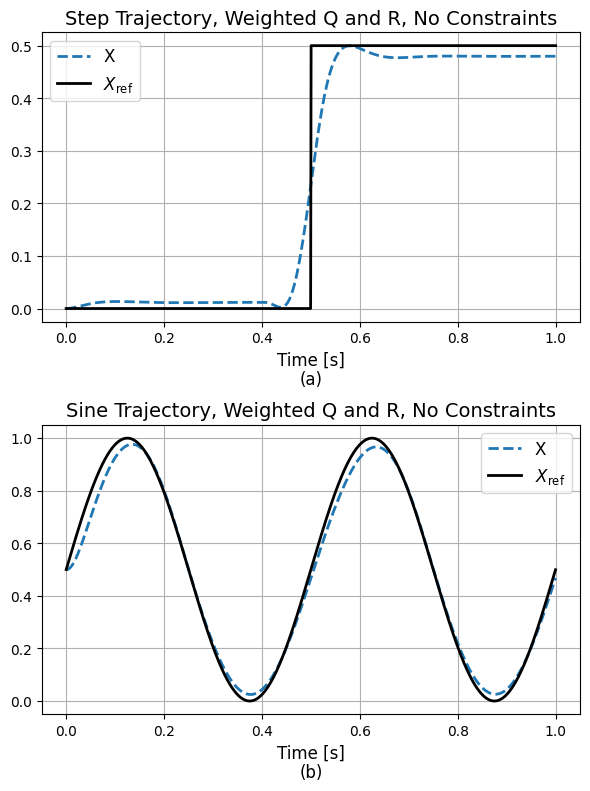

In [34]:
def cost_fun_leg(M_u,IC,M_x_des,Q,R):
    input_leg =torch.tensor(np.append(IC,M_u),dtype=torch.float32)#.to('cuda')
    with torch.no_grad():
        M_x = np.array(model(input_leg))#.to('cpu'))
    return np.matmul(np.transpose(M_x_des-M_x),np.matmul(Q,(M_x_des-M_x))) + np.matmul(np.transpose(M_u),np.matmul(R,(M_u)))

#Define weighting matrices
Q = 10 * np.eye(window_steps)
R = 2e-5* np.eye(window_steps)
P = leg.P[0:window_steps,:]
Q = np.matmul(np.transpose(P),np.matmul(Q,P))
R = np.matmul(np.transpose(P),np.matmul(R,P))


options = {
    'eps': 0.002,  
}

#Constants for sizing
t_steps = int(T/dt)
t_ref_steps = int((T+Np)/dt)
window_steps = int(Np/dt)
time = np.linspace(0,T,t_steps)
ref_time = np.linspace(0,T+Np,t_ref_steps)

#Inital conditions and reference traj
IC = [0,0,0,0]
X_des = np.zeros(t_ref_steps)
X_des[int(0.5/dt):t_ref_steps] = 0.5*np.ones(t_ref_steps-int(0.5/dt))

#Initialize and run simulation for step
M_u = np.zeros(N)
U_rec = np.zeros(t_steps)
X = np.zeros((4,t_steps))
X[:,0] = IC
start_time = timer.time()
for t in range(1,t_steps): #Loop through sim time
    M_x_des = leg.encode(X_des[t-1:t-1+window_steps]) #Encode ref trajectory
    IC = X[:,t-1] 
    res = minimize(cost_fun_leg, M_u ,method='SLSQP', args = (IC,M_x_des,Q,R),options = options) #Run optimization
    M_u = res.x
    U = leg.decode(res.x) #Decode U trajectory
    U_rec[t] = U[0]
    X[:,t] = sys.dynamics(X[:,t-1],U[0]) #Integrate dynamics
end_time = timer.time()
Step_elapsed_time = end_time - start_time
Step_RMSE = np.sqrt(np.mean(( X[2,:] - X_des[0:t_steps] )**2))
Step_X = X[2,:]

#Inital conditions and reference traj
IC = [0,0,0.5,0]
X_des = 0.5+0.5*np.sin(4*np.pi*ref_time)

#Initialize and run simulation for sine
M_u = np.zeros(N)
U_rec = np.zeros(t_steps)
X = np.zeros((4,t_steps))
X[:,0] = IC
start_time = timer.time()
for t in range(1,t_steps): #Loop through sim time
    M_x_des = leg.encode(X_des[t-1:t-1+window_steps]) #Encode ref trajectory
    IC = X[:,t-1]
    res = minimize(cost_fun_leg, M_u ,method='SLSQP', args = (IC,M_x_des,Q,R),options = options) #Run optimization
    M_u = res.x
    U = leg.decode(res.x) #Decode U trajectory
    U_rec[t] = U[0]
    X[:,t] = sys.dynamics(X[:,t-1],U[0]) #Integrate dynamics
end_time = timer.time()
Sine_elapsed_time = end_time - start_time
Sine_RMSE = np.sqrt(np.mean(( X[2,:] - X_des[0:t_steps] )**2))
Sine_X = X[2,:]

# Print results
print(f'                 Step | Sine')
print(f"Elapsed time: {Step_elapsed_time:.4f} | {Sine_elapsed_time:.4f} ")
print(f'RMSE:          {Step_RMSE:.4f} | {Sine_RMSE:.4f}')

#Get ref trajectories for plotting
X_des_step = np.zeros(t_ref_steps)
X_des_step[int(0.5/dt):t_ref_steps] = 0.5*np.ones(t_ref_steps-int(0.5/dt))
X_des_sine = 0.5+0.5*np.sin(4*np.pi*ref_time)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

# First subplot: step_traj
ax1.plot(time, Step_X, linestyle='--', color='#1f77b4', label='X', linewidth=2)
ax1.plot(time, X_des_step[0:t_steps], linestyle='-', color='black', label=r'$X_{\text{ref}}$', linewidth=2)
ax1.set_xlabel('Time [s]', fontsize=12)
ax1.set_title('Step Trajectory, Weighted Q and R, No Constraints', fontsize=14)
ax1.grid(True)
ax1.legend(loc='best', fontsize=12)
ax1.text(0.5, -0.2, '(a)', transform=ax1.transAxes, fontsize=12, va='center', ha='center')

# Second subplot: sine_traj
ax2.plot(time, Sine_X, linestyle='--', color='#1f77b4', label='X', linewidth=2) #'#ff7f0e'
ax2.plot(time, X_des_sine[0:t_steps], linestyle='-', color='black', label=r'$X_{\text{ref}}$', linewidth=2)
ax2.set_xlabel('Time [s]', fontsize=12)
ax2.set_title('Sine Trajectory, Weighted Q and R, No Constraints', fontsize=14)
ax2.grid(True)
ax2.legend(loc='best', fontsize=12)
ax2.text(0.5, -0.2, '(b)', transform=ax2.transAxes, fontsize=12, va='center', ha='center')

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure
plt.savefig('Leg_QR_step_sine.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

## Closed Loop, Step and Sine, Q with terminal and control constraints

                 Step | Sine
Elapsed time: 32.9258 | 31.6410 
RMSE:          0.0331 | 0.0263


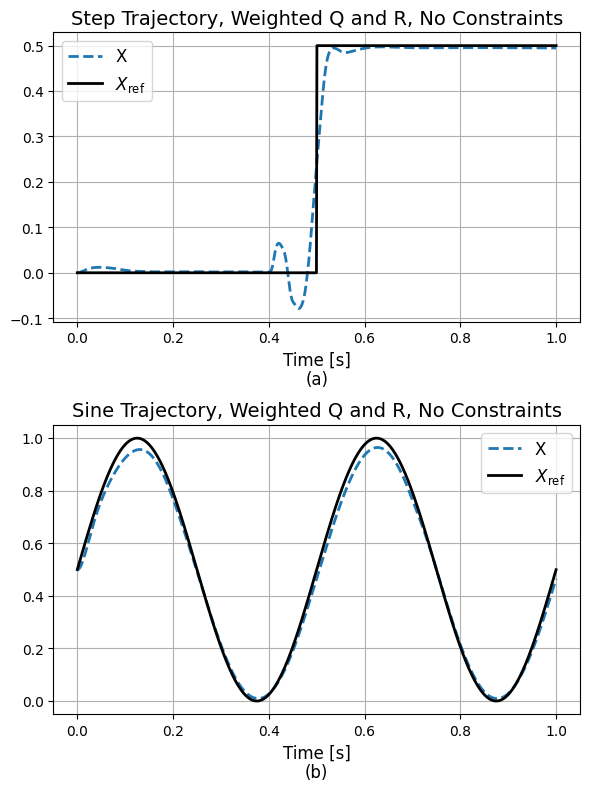

In [38]:
def cost_fun_leg(M_u,IC,M_x_des,Q,R):
    input_leg =torch.tensor(np.append(IC,M_u),dtype=torch.float32)#.to('cuda')
    with torch.no_grad():
        M_x = np.array(model(input_leg))#.to('cpu'))
    return np.matmul(np.transpose(M_x_des-M_x),np.matmul(Q,(M_x_des-M_x))) + np.matmul(np.transpose(M_u),np.matmul(R,(M_u)))

def terminal_decode(M_u):
    input_leg =torch.tensor(np.append(IC,M_u),dtype=torch.float32)#.to('cuda')
    with torch.no_grad():
        M_x = np.array(model(input_leg))#.to('cpu'))
    return np.sum(M_x-M_x_des)

def constraint_decode_specific_points(M_u):
    #sample_points = np.sort(np.random.uniform(0,int(Np/dt),num_sample_points)).astype(int)
    return np.matmul(leg.P[sample_points,:],M_u)

#Define weighting matrices
Q = 10 * np.eye(window_steps)
R = 0* np.eye(window_steps)
P = leg.P[0:window_steps,:]
Q = np.matmul(np.transpose(P),np.matmul(Q,P))
R = np.matmul(np.transpose(P),np.matmul(R,P))


options = {
    'eps': 0.002,  
}

#Constraints
terminal_lb = -0.1
terminal_ub = 0.1
terminal_state_constraint = NonlinearConstraint(terminal_decode,terminal_lb,terminal_ub)
num_sample_points = 10
U_lb = -500 * np.ones(num_sample_points)
U_ub = 500 * np.ones(num_sample_points)
U_sampled_constraint = NonlinearConstraint(constraint_decode_specific_points,U_lb,U_ub)
sample_points = np.linspace(0,window_steps,num_sample_points).astype(int)

#Constants for sizing
t_steps = int(T/dt)
t_ref_steps = int((T+Np)/dt)
window_steps = int(Np/dt)
time = np.linspace(0,T,t_steps)
ref_time = np.linspace(0,T+Np,t_ref_steps)

#Inital conditions and reference traj
IC = [0,0,0,0]
X_des = np.zeros(t_ref_steps)
X_des[int(0.5/dt):t_ref_steps] = 0.5*np.ones(t_ref_steps-int(0.5/dt))

#Initialize and run simulation for step
M_u = np.zeros(N)
U_rec = np.zeros(t_steps)
X = np.zeros((4,t_steps))
X[:,0] = IC
start_time = timer.time()
for t in range(1,t_steps): #Loop through sim time
    M_x_des = leg.encode(X_des[t-1:t-1+window_steps]) #Encode ref trajectory
    IC = X[:,t-1] 
    res = minimize(cost_fun_leg, M_u ,method='SLSQP', args = (IC,M_x_des,Q,R),options = options, constraints = {U_sampled_constraint,terminal_state_constraint}) #Run optimization
    M_u = res.x
    U = leg.decode(res.x) #Decode U trajectory
    U_rec[t] = U[0]
    X[:,t] = sys.dynamics(X[:,t-1],U[0]) #Integrate dynamics
end_time = timer.time()
Step_elapsed_time = end_time - start_time
Step_RMSE = np.sqrt(np.mean(( X[2,:] - X_des[0:t_steps] )**2))
Step_X = X[2,:]

#Inital conditions and reference traj
IC = [0,0,0.5,0]
X_des = 0.5+0.5*np.sin(4*np.pi*ref_time)

#Initialize and run simulation for sine
M_u = np.zeros(N)
U_rec = np.zeros(t_steps)
X = np.zeros((4,t_steps))
X[:,0] = IC
start_time = timer.time()
for t in range(1,t_steps): #Loop through sim time
    M_x_des = leg.encode(X_des[t-1:t-1+window_steps]) #Encode ref trajectory
    IC = X[:,t-1]
    res = minimize(cost_fun_leg, M_u ,method='SLSQP', args = (IC,M_x_des,Q,R),options = options,constraints = {U_sampled_constraint,terminal_state_constraint}) #Run optimization
    M_u = res.x
    U = leg.decode(res.x) #Decode U trajectory
    U_rec[t] = U[0]
    X[:,t] = sys.dynamics(X[:,t-1],U[0]) #Integrate dynamics
end_time = timer.time()
Sine_elapsed_time = end_time - start_time
Sine_RMSE = np.sqrt(np.mean(( X[2,:] - X_des[0:t_steps] )**2))
Sine_X = X[2,:]

# Print results
print(f'                 Step | Sine')
print(f"Elapsed time: {Step_elapsed_time:.4f} | {Sine_elapsed_time:.4f} ")
print(f'RMSE:          {Step_RMSE:.4f} | {Sine_RMSE:.4f}')

#Get ref trajectories for plotting
X_des_step = np.zeros(t_ref_steps)
X_des_step[int(0.5/dt):t_ref_steps] = 0.5*np.ones(t_ref_steps-int(0.5/dt))
X_des_sine = 0.5+0.5*np.sin(4*np.pi*ref_time)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

# First subplot: step_traj
ax1.plot(time, Step_X, linestyle='--', color='#1f77b4', label='X', linewidth=2)
ax1.plot(time, X_des_step[0:t_steps], linestyle='-', color='black', label=r'$X_{\text{ref}}$', linewidth=2)
ax1.set_xlabel('Time [s]', fontsize=12)
ax1.set_title('Step Trajectory, Weighted Q and R, No Constraints', fontsize=14)
ax1.grid(True)
ax1.legend(loc='best', fontsize=12)
ax1.text(0.5, -0.2, '(a)', transform=ax1.transAxes, fontsize=12, va='center', ha='center')

# Second subplot: sine_traj
ax2.plot(time, Sine_X, linestyle='--', color='#1f77b4', label='X', linewidth=2) #'#ff7f0e'
ax2.plot(time, X_des_sine[0:t_steps], linestyle='-', color='black', label=r'$X_{\text{ref}}$', linewidth=2)
ax2.set_xlabel('Time [s]', fontsize=12)
ax2.set_title('Sine Trajectory, Weighted Q and R, No Constraints', fontsize=14)
ax2.grid(True)
ax2.legend(loc='best', fontsize=12)
ax2.text(0.5, -0.2, '(b)', transform=ax2.transAxes, fontsize=12, va='center', ha='center')

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure
plt.savefig('Leg_QConstraints_step_sine.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()